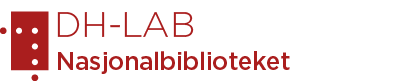

In [1]:
#!pip install -U dhlab
import dhlab as dh

wordcloud er ikke installert, kan ikke lage ordskyer


# Korpusdefinisjon
Her viser vi ulike måter man kan bygge et korpus, et tekstutvalg, fra NBs samling. Avgrensningen kan defineres med utgivelsens metadata, eller innhold i selve teksten.

Korpuset man får tilbake er en samling dokument-IDer (URN = uniform resource name) og metadata. En URN refererer til en enkeltutgave av en publikasjon som er skannet hos NB.
Metadata kan være dewey desimalkode, bibliografiske emneord, tittel, forfatter, publikasjonsår og -dato, etc. 
Her kan [Webdewey](http://deweysearchno.pansoft.de/webdeweysearch/index.html) være til god hjelp.

**Tips:** 
Trykk `shift`+`tab` i parentesen i en funksjon (f.eks. `dh.Corpus(...)` ) for å se hvilke parametre som kan søkes på, og hva som er default-innstillinger.

## 1. Bygg aviskorpus fra metadata

Fyll inn variablene i kodeblokken nedenfor. 


- `search_term`: Nøkkelord som skal forekomme minst én gang per utgivelse i korpuset
- `from_year`: Start på tidsperiode, fra 01.01. det året.
- `to_year`: Slutt på tidsperiode, til 31.12. det året.
- valgfrie variabler: 
  - `limit`: Maks antall avisutgivelser per dag. 
    - OBS! Et høyt tall vil gi ekstremt store utvalg per dag og ta lang tid å prosessere.
  - `cities`: publikasjonssted(er) for avisen. 
    - Kan ha flere verdier, separert med komma eller linjeskift. Eksempler:
      -  `"Stavanger"`
      -  `"Stavanger,Oslo,Kristiansand"`
      -  ```
         """
         Stavanger
         Oslo
         Kristiansand
         """
         ```
  - `title`: Avistittel.  
    - OBS! små bokstaver, ingen spesialtegn (æøå), ingen mellomrom i hver tittel. 
    - Titler kan være kommaseparert eller linjeseparert. Eksempler:
      - `"askoyvaeringen"`
      - `"askoyvaeringen,kystogfjord"`
      - ```
         """
         askoyvaeringen
         kystogfjord
         fiskeribladettjue
         """
         ```

In [4]:
# Angi et gitt nøkkelord som skal forekomme minst én gang per utgivelse i korpuset i avisteksten
search_term = "barnevern"

# Tidsperiode
from_year = 1999
to_year = 2022

# begrensning på antall aviser per dag
docs_per_day = 10

# Avistitler
titles = ""      

## Publikasjonssted for avisen(e)
cities = ""

In [5]:
# FIXME: Flytt funksjoner inn i modul


def make_list(value):
    """Turn a string or list into a list.

    :param value: Can be a list, a single valued string, a comma-separated string of values,
        or a multiline string of values separated by newline.

    """
    if isinstance(value, str):
        if value.__contains__("\n"):
            newlist = value.strip("\n").strip().split("\n")
        elif value.__contains__(","):
            newlist = value.split(",")
        else:
            newlist = [value]
        return [v.strip() for v in newlist]
    else:
        assert isinstance(value, list)
        return value


def timestamp_generator(from_year, to_year):
    """Generate a timestamp per day in the period ``from_year``-``to_year``."""
    # range of timestamps
    timestamp_range = pd.date_range(start=f"{from_year}-01-01", end=f"{to_year}-12-31")

    for i in timestamp_range:
        date = "".join(str(i).split()[0].split("-"))
        yield date


def read_spreadsheet(file_path):
    return pd.read_excel(file_path) if file_path.endswith(".xlsx") else pd.read_csv(file_path)


def specific_news_corpus(**params):
        r = requests.post("https://api.nb.no/dhlab/build_corpus", json=params)
        assert (r.status_code == 200) and (r.json())
        return r.json()

def corpus_generator_json(
    keyword: str = search_term, 
    from_year: int = from_year,
    to_year: int = to_year,
    limit: int = 10
) -> dict:
    """Generate a large corpus of daily newspapers where ``keyword`` appears."""
    for date in timestamp_generator(from_year, to_year):
        parameters = {
            "doctype": "digavis",
            #"title":title,
            #"city": city,
            "freetext": f"timestamp: {date}",
            "fulltext": keyword,
            "limit": limit
            }
        try:
            json_obj = specific_news_corpus(**parameters)
            yield json_obj
        except AssertionError as e:
            continue

def corpus_generator_df(
    keyword: str = search_term, 
    from_year: int = from_year,
    to_year: int = to_year,
    limit: int = 10
) -> dh.Corpus:
    for date in timestamp_generator(from_year, to_year):
        subcorpus = dh.Corpus(doctype="digavis", fulltext=keyword, freetext=f"timestamp: {date}", limit=limit)
        if subcorpus.frame.empty:
            continue
        else: 
            yield subcorpus

def strip_empty_cols(dhobj): 
    return dhobj.frame.dropna(axis=1, how="all").fillna("")


In [ ]:
# Bygg korpus iterativt av aviser for tidsperioden der "search_term" forekommer

subcorpgen = corpus_generator_df(
    keyword=search_term, from_year=1999, to_year=2000, limit=docs_per_day)


In [6]:
keyword=search_term
date = 20010612
limit=10
subcorpus = dh.Corpus(
    doctype="digavis", 
    fulltext=keyword, 
    freetext=f"timestamp: {date}", 
    limit=limit)

def strip_empty_cols(dhobj): 
    return dhobj.frame.dropna(axis=1, how="all").fillna("")

news_meta_df = strip_empty_cols(subcorpus)

In [9]:
korpus = dh.Corpus(
    doctype="digavis", 
    author=None, 
    freetext=None, 
    fulltext="barnevern",  # ord som skal forekomme i teksten
    from_year=1990, 
    to_year=2000, 
    from_timestamp=None, 
    to_timestamp=None, 
    title=None,           # Navn på avis
    ddk=None, 
    subject=None,  
    lang=None,        # 3-sifrede Språkkoder (f.eks. "nob", "nno")
    limit=50000       # Antall dokumenter (her: antall avisutgaver) 
)


In [2]:
dataframe = korpus.corpus
dataframe.title.unique()

NameError: name 'korpus' is not defined

In [11]:
dataframe["urn"][0]

'URN:NBN:no-nb_digavis_fiskeribladet_null_null_19920722_47_50_1'

### 1.2. Lagre korpuset til csv

In [5]:
filsti = 'korpus_aviser_2006-2020.csv'

In [6]:
dataframe.to_csv(filsti)

### 1.3. Last opp korpus fra csv 

In [37]:
import pandas as pd 

korpus = pd.read_csv(filsti)


Tilbake til [DHLAB ved Nasjonalbiblioteket](https://nbviewer.jupyter.org/github/DH-LAB-NB/DHLAB/blob/master/DHLAB_ved_Nasjonalbiblioteket.ipynb)